In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive

In [3]:
# !pip install datasets evaluate transformers
# !pip install accelerate -U
# !pip install transformers[torch]

In [4]:
# !pip install accelerate --upgrade

In [5]:
import numpy as np
import pandas as pd
import os

from datasets import load_dataset, DatasetDict, concatenate_datasets

import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)

import matplotlib.pyplot as plt

c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
INPUT_DIR = "./"
OUTPUT_DIR = "./output/bert"
CHECKPOINT = "google-bert/bert-base-multilingual-uncased"

In [7]:
# Load data
data = load_dataset("csv", data_files=os.path.join(INPUT_DIR, "train.csv"), trust_remote_code=True, split="train")

data = data.train_test_split(0.2)

translated_data = load_dataset("csv", data_files=os.path.join(INPUT_DIR, "translated.csv"), trust_remote_code=True, split="train")

train_data = concatenate_datasets([data['train'], translated_data])
train_data = train_data.shuffle(seed=42)

data = DatasetDict(
    {
        "train": train_data,
        "val": data["test"],
        "test": load_dataset("csv", data_files=os.path.join(INPUT_DIR, "test.csv"), trust_remote_code=True, split="train"),
    }
)
data

# # Load data
# data = load_dataset("csv", data_files=os.path.join(INPUT_DIR, "train.csv"), trust_remote_code=True, split="train")

# data = data.train_test_split(0.2)

# data = DatasetDict(
#     {
#         "train": data["train"],
#         "val": data["test"],
#         "test": load_dataset("csv", data_files=os.path.join(INPUT_DIR, "test.csv"), trust_remote_code=True, split="train"),
#     }
# )
# data

DatasetDict({
    train: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 105876
    })
    val: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label'],
        num_rows: 2424
    })
    test: Dataset({
        features: ['id', 'premise', 'hypothesis', 'lang_abv', 'language'],
        num_rows: 5195
    })
})

In [8]:
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT, truncation=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=3)
model

import torch
import torch.nn as nn

class CNNCls(nn.Module):
    def __init__(self):
        super(CNNCls, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)
        x = x.mean(dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class CNN3Cls(nn.Module):
    def __init__(self):
        super(CNN3Cls, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=768, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=768, out_channels=512, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)
        x = x.mean(dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class LSTMCls(nn.Module):
    def __init__(self):
        super(LSTMCls, self).__init__()
        self.lstm = nn.LSTM(input_size=768, hidden_size=256, num_layers=1, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # LSTM返回两个元组，(output, (h_n, c_n))
        # output: (batch_size, seq_length, num_directions * hidden_size)
        # h_n: (num_layers * num_directions, batch_size, hidden_size)
        # c_n: (num_layers * num_directions, batch_size, hidden_size)
        output, (h_n, c_n) = self.lstm(x)
        x = self.relu(output)  # 取序列的最后一个输出
        x = self.dropout(x)
        x = self.fc(x)
        return x

class GRUCls(nn.Module):
    def __init__(self):
        super(GRUCls, self).__init__()
        self.gru = nn.GRU(input_size=768, hidden_size=256, num_layers=1, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # GRU的输出 (output, h_n)
        output, h_n = self.gru(x)  # output: (batch_size, seq_length, hidden_size)
        x = self.relu(output)  # 取序列的最后一个输出
        x = self.dropout(x)
        x = self.fc(x)
        return x

class RNNCls(nn.Module):
    def __init__(self):
        super(RNNCls, self).__init__()
        self.rnn = nn.RNN(input_size=768, hidden_size=256, num_layers=1, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, 3)

    def forward(self, x):
        # RNN的输出包括 (output, h_n)
        output, h_n = self.rnn(x)  # output: (batch_size, seq_length, hidden_size)
        x = self.relu(output)  # 取序列的最后一个输出
        x = self.dropout(x)
        x = self.fc(x)
        return x

class MultiheadAttentionCls(nn.Module):
    def __init__(self):
        super(MultiheadAttentionCls, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(768, 3)

    def forward(self, x):
        # 假设x的形状是(batch_size, seq_length, embed_dim)
        # 多头注意力需要输入key, query, value，这里我们使用同一个x作为三者
        attn_output, _ = self.attention(x, x, x)
        # 取多头注意力输出的平均或者最后一个时间步的输出
        x = self.relu(attn_output)
        x = self.dropout(x)
        x = self.fc(x)
        return x


from transformers import BertModel

class CustomBERTModel(nn.Module):
    def __init__(self, num_labels):
        super(CustomBERTModel, self).__init__()
        model_name = CHECKPOINT
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_labels)
        )
        self.loss = nn.CrossEntropyLoss()
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.dropout(output.pooler_output)
        logits = self.classifier(output)

        if labels is not None:
            loss = self.loss(logits.view(-1, self.num_labels), labels.view(-1))
            return {"loss": loss, "logits": logits}
        else:
            return logits

# model = CustomBERTModel(num_labels=3)
model.classifier = RNNCls()
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [9]:
def preprocess_data(batch):
    batch["text"] = [
        x1 + f" {tokenizer.sep_token} " + x2
        for x1, x2 in zip(batch["premise"], batch["hypothesis"])
    ]
    return tokenizer(batch["text"])

data = data.map(preprocess_data, batched=True)

Map: 100%|██████████| 2424/2424 [00:00<00:00, 17704.91 examples/s]


In [10]:
data['train'][0]


{'id': 'f714ec0aebde',
 'premise': 'Als seine Stiefmutter davon erfuhr, machte sie ihm am Nachmittag vor ihrem Tod diese Vorwürfe, und es kam zu einem Streit, der teilweise mitgehört wurde. ',
 'hypothesis': 'Für die letzten Worte, die er vor ihrem Tod zu ihr gesprochen hatte, fühlte er sich sein Leben lang schuldig.',
 'lang_abv': 'de',
 'language': 'German',
 'label': 1,
 'text': 'Als seine Stiefmutter davon erfuhr, machte sie ihm am Nachmittag vor ihrem Tod diese Vorwürfe, und es kam zu einem Streit, der teilweise mitgehört wurde.  [SEP] Für die letzten Worte, die er vor ihrem Tod zu ihr gesprochen hatte, fühlte er sich sein Leben lang schuldig.',
 'input_ids': [101,
  10233,
  11213,
  83684,
  63198,
  61672,
  10177,
  20190,
  10162,
  75341,
  117,
  24310,
  10271,
  13285,
  10345,
  10439,
  93018,
  13650,
  11239,
  17827,
  16789,
  11772,
  11239,
  89978,
  10111,
  117,
  10138,
  10153,
  12613,
  10331,
  10847,
  75615,
  117,
  10118,
  22723,
  10234,
  10592,
  7

In [11]:
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    return metric.compute(predictions=preds, references=labels)

train_args = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, "results"),
    logging_dir=os.path.join(OUTPUT_DIR, "logs"),
    report_to=[],
    evaluation_strategy="steps",
    eval_steps=200,
    logging_steps=200,
    save_steps=200,
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.005,
    num_train_epochs=1,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=3,
    save_only_model=True,
)

In [12]:
trainer = Trainer(
    model=model,
    args=train_args,
    data_collator=data_collator,
    train_dataset=data["train"],
    eval_dataset=data["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

c:\Users\andyp\AppData\Local\Programs\Python\Python311\Lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
  3%|▎         | 200/6618 [00:30<15:49,  6.76it/s]

{'loss': 1.0891, 'grad_norm': 3.4674887657165527, 'learning_rate': 1.9395587790873378e-05, 'epoch': 0.03}


                                                  
  3%|▎         | 200/6618 [00:35<15:49,  6.76it/s]Removed shared tensor {'classifier.rnn.bias_ih_l0', 'classifier.rnn.bias_hh_l0', 'classifier.rnn.weight_hh_l0'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


{'eval_loss': 1.0480149984359741, 'eval_accuracy': 0.45503300330033003, 'eval_runtime': 5.0071, 'eval_samples_per_second': 484.11, 'eval_steps_per_second': 30.357, 'epoch': 0.03}


  6%|▌         | 400/6618 [01:06<14:39,  7.07it/s]  

{'loss': 0.9799, 'grad_norm': 8.015278816223145, 'learning_rate': 1.8797219703838018e-05, 'epoch': 0.06}


                                                  
  6%|▌         | 400/6618 [01:12<14:39,  7.07it/s]

{'eval_loss': 0.9121776819229126, 'eval_accuracy': 0.5862211221122112, 'eval_runtime': 5.5772, 'eval_samples_per_second': 434.629, 'eval_steps_per_second': 27.254, 'epoch': 0.06}


  9%|▉         | 600/6618 [01:43<14:59,  6.69it/s]  

{'loss': 0.9624, 'grad_norm': 7.383638858795166, 'learning_rate': 1.8192807494711394e-05, 'epoch': 0.09}


                                                  
  9%|▉         | 600/6618 [01:49<14:59,  6.69it/s]

{'eval_loss': 0.9040164947509766, 'eval_accuracy': 0.5870462046204621, 'eval_runtime': 5.3574, 'eval_samples_per_second': 452.458, 'eval_steps_per_second': 28.372, 'epoch': 0.09}


 12%|█▏        | 800/6618 [02:20<13:51,  7.00it/s]  

{'loss': 0.9155, 'grad_norm': 9.521387100219727, 'learning_rate': 1.758839528558477e-05, 'epoch': 0.12}


                                                  
 12%|█▏        | 800/6618 [02:26<13:51,  7.00it/s]

{'eval_loss': 0.8522412180900574, 'eval_accuracy': 0.6283003300330033, 'eval_runtime': 5.6892, 'eval_samples_per_second': 426.068, 'eval_steps_per_second': 26.717, 'epoch': 0.12}


 15%|█▌        | 1000/6618 [02:58<13:18,  7.04it/s] 

{'loss': 0.9134, 'grad_norm': 7.6052565574646, 'learning_rate': 1.6983983076458146e-05, 'epoch': 0.15}


                                                   
 15%|█▌        | 1000/6618 [03:04<13:18,  7.04it/s]

{'eval_loss': 0.8476641178131104, 'eval_accuracy': 0.6208745874587459, 'eval_runtime': 5.5288, 'eval_samples_per_second': 438.428, 'eval_steps_per_second': 27.492, 'epoch': 0.15}


 18%|█▊        | 1200/6618 [03:35<12:58,  6.96it/s]  

{'loss': 0.901, 'grad_norm': 8.199238777160645, 'learning_rate': 1.6379570867331522e-05, 'epoch': 0.18}


                                                   
 18%|█▊        | 1200/6618 [03:41<12:58,  6.96it/s]

{'eval_loss': 0.8399881720542908, 'eval_accuracy': 0.6192244224422442, 'eval_runtime': 5.6287, 'eval_samples_per_second': 430.651, 'eval_steps_per_second': 27.005, 'epoch': 0.18}


 21%|██        | 1400/6618 [04:13<12:28,  6.97it/s]  

{'loss': 0.878, 'grad_norm': 6.68585205078125, 'learning_rate': 1.5775158658204898e-05, 'epoch': 0.21}


                                                   
 21%|██        | 1400/6618 [04:18<12:28,  6.97it/s]

{'eval_loss': 0.8087708353996277, 'eval_accuracy': 0.6402640264026402, 'eval_runtime': 5.2864, 'eval_samples_per_second': 458.539, 'eval_steps_per_second': 28.753, 'epoch': 0.21}


 24%|██▍       | 1600/6618 [04:50<12:20,  6.77it/s]  

{'loss': 0.8485, 'grad_norm': 8.831063270568848, 'learning_rate': 1.5170746449078272e-05, 'epoch': 0.24}


                                                   
 24%|██▍       | 1600/6618 [04:55<12:20,  6.77it/s]

{'eval_loss': 0.80534428358078, 'eval_accuracy': 0.6406765676567657, 'eval_runtime': 5.2407, 'eval_samples_per_second': 462.533, 'eval_steps_per_second': 29.004, 'epoch': 0.24}


 27%|██▋       | 1800/6618 [05:27<11:57,  6.72it/s]  

{'loss': 0.8676, 'grad_norm': 8.429427146911621, 'learning_rate': 1.4566334239951647e-05, 'epoch': 0.27}


                                                   
 27%|██▋       | 1800/6618 [05:32<11:57,  6.72it/s]

{'eval_loss': 0.7841135263442993, 'eval_accuracy': 0.6600660066006601, 'eval_runtime': 5.4285, 'eval_samples_per_second': 446.534, 'eval_steps_per_second': 28.0, 'epoch': 0.27}


 30%|███       | 2000/6618 [06:05<11:28,  6.71it/s]  

{'loss': 0.8478, 'grad_norm': 8.009357452392578, 'learning_rate': 1.3961922030825024e-05, 'epoch': 0.3}


                                                   
 30%|███       | 2000/6618 [06:10<11:28,  6.71it/s]

{'eval_loss': 0.7918615341186523, 'eval_accuracy': 0.6485148514851485, 'eval_runtime': 5.6394, 'eval_samples_per_second': 429.833, 'eval_steps_per_second': 26.953, 'epoch': 0.3}


 33%|███▎      | 2200/6618 [06:42<10:27,  7.04it/s]  

{'loss': 0.8345, 'grad_norm': 7.976894855499268, 'learning_rate': 1.33575098216984e-05, 'epoch': 0.33}


                                                   
 33%|███▎      | 2200/6618 [06:47<10:27,  7.04it/s]

{'eval_loss': 0.7661153078079224, 'eval_accuracy': 0.6641914191419142, 'eval_runtime': 4.8131, 'eval_samples_per_second': 503.621, 'eval_steps_per_second': 31.58, 'epoch': 0.33}


 36%|███▋      | 2400/6618 [07:18<10:13,  6.88it/s]  

{'loss': 0.8047, 'grad_norm': 12.95920467376709, 'learning_rate': 1.2753097612571774e-05, 'epoch': 0.36}


                                                   
 36%|███▋      | 2400/6618 [07:23<10:13,  6.88it/s]

{'eval_loss': 0.7702425122261047, 'eval_accuracy': 0.6551155115511551, 'eval_runtime': 5.5569, 'eval_samples_per_second': 436.213, 'eval_steps_per_second': 27.353, 'epoch': 0.36}


 39%|███▉      | 2600/6618 [07:55<09:26,  7.10it/s]  

{'loss': 0.7891, 'grad_norm': 9.123123168945312, 'learning_rate': 1.2151707464490783e-05, 'epoch': 0.39}


                                                   
 39%|███▉      | 2600/6618 [08:00<09:26,  7.10it/s]

{'eval_loss': 0.751711905002594, 'eval_accuracy': 0.6712046204620462, 'eval_runtime': 5.3719, 'eval_samples_per_second': 451.239, 'eval_steps_per_second': 28.296, 'epoch': 0.39}


 42%|████▏     | 2800/6618 [08:32<08:57,  7.11it/s]  

{'loss': 0.8021, 'grad_norm': 10.875104904174805, 'learning_rate': 1.1547295255364159e-05, 'epoch': 0.42}


                                                   
 42%|████▏     | 2800/6618 [08:37<08:57,  7.11it/s]

{'eval_loss': 0.7391440868377686, 'eval_accuracy': 0.6872937293729373, 'eval_runtime': 4.6299, 'eval_samples_per_second': 523.552, 'eval_steps_per_second': 32.83, 'epoch': 0.42}


 45%|████▌     | 3000/6618 [09:08<08:42,  6.93it/s]  

{'loss': 0.7698, 'grad_norm': 8.786696434020996, 'learning_rate': 1.0942883046237536e-05, 'epoch': 0.45}


                                                   
 45%|████▌     | 3000/6618 [09:14<08:42,  6.93it/s]

{'eval_loss': 0.7455416917800903, 'eval_accuracy': 0.6765676567656765, 'eval_runtime': 5.5306, 'eval_samples_per_second': 438.286, 'eval_steps_per_second': 27.483, 'epoch': 0.45}


 48%|████▊     | 3200/6618 [09:46<07:58,  7.14it/s]  

{'loss': 0.797, 'grad_norm': 10.889054298400879, 'learning_rate': 1.033847083711091e-05, 'epoch': 0.48}


                                                   
 48%|████▊     | 3200/6618 [09:52<07:58,  7.14it/s]

{'eval_loss': 0.7351437211036682, 'eval_accuracy': 0.6786303630363036, 'eval_runtime': 5.6819, 'eval_samples_per_second': 426.62, 'eval_steps_per_second': 26.752, 'epoch': 0.48}


 51%|█████▏    | 3400/6618 [10:25<07:48,  6.87it/s]  

{'loss': 0.7802, 'grad_norm': 9.20958423614502, 'learning_rate': 9.734058627984287e-06, 'epoch': 0.51}


                                                   
 51%|█████▏    | 3400/6618 [10:30<07:48,  6.87it/s]

{'eval_loss': 0.7279499769210815, 'eval_accuracy': 0.6831683168316832, 'eval_runtime': 5.6278, 'eval_samples_per_second': 430.717, 'eval_steps_per_second': 27.009, 'epoch': 0.51}


 54%|█████▍    | 3600/6618 [11:03<07:08,  7.05it/s]  

{'loss': 0.761, 'grad_norm': 14.878654479980469, 'learning_rate': 9.129646418857661e-06, 'epoch': 0.54}


                                                   
 54%|█████▍    | 3600/6618 [11:08<07:08,  7.05it/s]

{'eval_loss': 0.7390096187591553, 'eval_accuracy': 0.6728547854785478, 'eval_runtime': 5.4154, 'eval_samples_per_second': 447.613, 'eval_steps_per_second': 28.068, 'epoch': 0.54}


 57%|█████▋    | 3800/6618 [11:40<06:39,  7.06it/s]  

{'loss': 0.7552, 'grad_norm': 13.915786743164062, 'learning_rate': 8.525234209731037e-06, 'epoch': 0.57}


                                                   
 57%|█████▋    | 3800/6618 [11:45<06:39,  7.06it/s]

{'eval_loss': 0.7388238906860352, 'eval_accuracy': 0.679042904290429, 'eval_runtime': 5.454, 'eval_samples_per_second': 444.447, 'eval_steps_per_second': 27.87, 'epoch': 0.57}


 60%|██████    | 4000/6618 [12:18<06:11,  7.04it/s]  

{'loss': 0.7596, 'grad_norm': 12.445393562316895, 'learning_rate': 7.920822000604413e-06, 'epoch': 0.6}


                                                   
 60%|██████    | 4000/6618 [12:23<06:11,  7.04it/s]

{'eval_loss': 0.7218323349952698, 'eval_accuracy': 0.6934818481848185, 'eval_runtime': 5.375, 'eval_samples_per_second': 450.981, 'eval_steps_per_second': 28.279, 'epoch': 0.6}


 63%|██████▎   | 4200/6618 [12:56<05:27,  7.38it/s]  

{'loss': 0.7395, 'grad_norm': 13.107863426208496, 'learning_rate': 7.316409791477789e-06, 'epoch': 0.63}


                                                   
 63%|██████▎   | 4200/6618 [13:01<05:27,  7.38it/s]

{'eval_loss': 0.7201048731803894, 'eval_accuracy': 0.6901815181518152, 'eval_runtime': 5.7417, 'eval_samples_per_second': 422.174, 'eval_steps_per_second': 26.473, 'epoch': 0.63}


 66%|██████▋   | 4400/6618 [13:38<07:23,  5.00it/s]  

{'loss': 0.7414, 'grad_norm': 8.498091697692871, 'learning_rate': 6.711997582351164e-06, 'epoch': 0.66}


                                                   
 66%|██████▋   | 4400/6618 [13:42<07:23,  5.00it/s]

{'eval_loss': 0.710347592830658, 'eval_accuracy': 0.6996699669966997, 'eval_runtime': 4.406, 'eval_samples_per_second': 550.165, 'eval_steps_per_second': 34.499, 'epoch': 0.66}


 70%|██████▉   | 4600/6618 [14:20<06:15,  5.38it/s]  

{'loss': 0.7211, 'grad_norm': 9.212361335754395, 'learning_rate': 6.107585373224539e-06, 'epoch': 0.7}


                                                   
 70%|██████▉   | 4600/6618 [14:25<06:15,  5.38it/s]

{'eval_loss': 0.7050771117210388, 'eval_accuracy': 0.7000825082508251, 'eval_runtime': 4.8828, 'eval_samples_per_second': 496.437, 'eval_steps_per_second': 31.13, 'epoch': 0.7}


 73%|███████▎  | 4800/6618 [15:00<06:43,  4.51it/s]  

{'loss': 0.7332, 'grad_norm': 11.973102569580078, 'learning_rate': 5.506195225143548e-06, 'epoch': 0.73}


                                                   
 73%|███████▎  | 4800/6618 [15:05<06:43,  4.51it/s]

{'eval_loss': 0.7179664373397827, 'eval_accuracy': 0.6976072607260726, 'eval_runtime': 4.5267, 'eval_samples_per_second': 535.485, 'eval_steps_per_second': 33.578, 'epoch': 0.73}


 76%|███████▌  | 5000/6618 [15:45<05:53,  4.58it/s]

{'loss': 0.728, 'grad_norm': 24.09558868408203, 'learning_rate': 4.901783016016924e-06, 'epoch': 0.76}


                                                   
 76%|███████▌  | 5000/6618 [15:51<05:53,  4.58it/s]

{'eval_loss': 0.7241004705429077, 'eval_accuracy': 0.6905940594059405, 'eval_runtime': 5.4662, 'eval_samples_per_second': 443.449, 'eval_steps_per_second': 27.807, 'epoch': 0.76}


 79%|███████▊  | 5200/6618 [16:27<03:16,  7.22it/s]  

{'loss': 0.7104, 'grad_norm': 12.56181526184082, 'learning_rate': 4.2973708068903e-06, 'epoch': 0.79}


                                                   
 79%|███████▊  | 5200/6618 [16:32<03:16,  7.22it/s]

{'eval_loss': 0.6977733373641968, 'eval_accuracy': 0.6988448844884488, 'eval_runtime': 5.5827, 'eval_samples_per_second': 434.202, 'eval_steps_per_second': 27.227, 'epoch': 0.79}


 82%|████████▏ | 5400/6618 [17:11<03:05,  6.57it/s]

{'loss': 0.7321, 'grad_norm': 12.190526962280273, 'learning_rate': 3.692958597763675e-06, 'epoch': 0.82}


                                                   
 82%|████████▏ | 5400/6618 [17:17<03:05,  6.57it/s]

{'eval_loss': 0.6835179924964905, 'eval_accuracy': 0.7108085808580858, 'eval_runtime': 5.3698, 'eval_samples_per_second': 451.412, 'eval_steps_per_second': 28.306, 'epoch': 0.82}


 85%|████████▍ | 5600/6618 [17:56<03:33,  4.77it/s]

{'loss': 0.7157, 'grad_norm': 7.305642604827881, 'learning_rate': 3.088546388637051e-06, 'epoch': 0.85}


                                                   
 85%|████████▍ | 5600/6618 [18:01<03:33,  4.77it/s]

{'eval_loss': 0.6906147599220276, 'eval_accuracy': 0.7091584158415841, 'eval_runtime': 5.1938, 'eval_samples_per_second': 466.713, 'eval_steps_per_second': 29.266, 'epoch': 0.85}


 88%|████████▊ | 5800/6618 [18:42<02:24,  5.68it/s]

{'loss': 0.7093, 'grad_norm': 19.10758399963379, 'learning_rate': 2.4841341795104264e-06, 'epoch': 0.88}


                                                   
 88%|████████▊ | 5800/6618 [18:46<02:24,  5.68it/s]

{'eval_loss': 0.6857695579528809, 'eval_accuracy': 0.7066831683168316, 'eval_runtime': 4.4925, 'eval_samples_per_second': 539.562, 'eval_steps_per_second': 33.834, 'epoch': 0.88}


 91%|█████████ | 6000/6618 [19:22<01:36,  6.42it/s]

{'loss': 0.7184, 'grad_norm': 13.344358444213867, 'learning_rate': 1.879721970383802e-06, 'epoch': 0.91}


                                                   
 91%|█████████ | 6000/6618 [19:27<01:36,  6.42it/s]

{'eval_loss': 0.6897754073143005, 'eval_accuracy': 0.7165841584158416, 'eval_runtime': 4.3875, 'eval_samples_per_second': 552.473, 'eval_steps_per_second': 34.643, 'epoch': 0.91}


 94%|█████████▎| 6200/6618 [20:03<01:06,  6.27it/s]

{'loss': 0.7041, 'grad_norm': 11.30181884765625, 'learning_rate': 1.2753097612571774e-06, 'epoch': 0.94}


                                                   
 94%|█████████▎| 6200/6618 [20:08<01:06,  6.27it/s]

{'eval_loss': 0.6907715201377869, 'eval_accuracy': 0.7161716171617162, 'eval_runtime': 4.4518, 'eval_samples_per_second': 544.504, 'eval_steps_per_second': 34.144, 'epoch': 0.94}


 97%|█████████▋| 6400/6618 [20:46<00:43,  5.00it/s]

{'loss': 0.6804, 'grad_norm': 13.407471656799316, 'learning_rate': 6.708975521305532e-07, 'epoch': 0.97}


                                                   
 97%|█████████▋| 6400/6618 [20:51<00:43,  5.00it/s]

{'eval_loss': 0.686680793762207, 'eval_accuracy': 0.7186468646864687, 'eval_runtime': 4.4399, 'eval_samples_per_second': 545.958, 'eval_steps_per_second': 34.235, 'epoch': 0.97}


100%|█████████▉| 6600/6618 [21:27<00:03,  5.98it/s]

{'loss': 0.7108, 'grad_norm': 12.52430534362793, 'learning_rate': 6.648534300392869e-08, 'epoch': 1.0}


                                                   
100%|█████████▉| 6600/6618 [21:32<00:03,  5.98it/s]

{'eval_loss': 0.6871473789215088, 'eval_accuracy': 0.7149339933993399, 'eval_runtime': 4.389, 'eval_samples_per_second': 552.286, 'eval_steps_per_second': 34.632, 'epoch': 1.0}


100%|██████████| 6618/6618 [21:36<00:00,  5.10it/s]

{'train_runtime': 1296.4242, 'train_samples_per_second': 81.668, 'train_steps_per_second': 5.105, 'train_loss': 0.7995945851800664, 'epoch': 1.0}


TrainOutput(global_step=6618, training_loss=0.7995945851800664, metrics={'train_runtime': 1296.4242, 'train_samples_per_second': 81.668, 'train_steps_per_second': 5.105, 'train_loss': 0.7995945851800664, 'epoch': 1.0})

In [13]:
log = trainer.state.log_history
log

[{'loss': 1.0891,
  'grad_norm': 3.4674887657165527,
  'learning_rate': 1.9395587790873378e-05,
  'epoch': 0.03,
  'step': 200},
 {'eval_loss': 1.0480149984359741,
  'eval_accuracy': 0.45503300330033003,
  'eval_runtime': 5.0071,
  'eval_samples_per_second': 484.11,
  'eval_steps_per_second': 30.357,
  'epoch': 0.03,
  'step': 200},
 {'loss': 0.9799,
  'grad_norm': 8.015278816223145,
  'learning_rate': 1.8797219703838018e-05,
  'epoch': 0.06,
  'step': 400},
 {'eval_loss': 0.9121776819229126,
  'eval_accuracy': 0.5862211221122112,
  'eval_runtime': 5.5772,
  'eval_samples_per_second': 434.629,
  'eval_steps_per_second': 27.254,
  'epoch': 0.06,
  'step': 400},
 {'loss': 0.9624,
  'grad_norm': 7.383638858795166,
  'learning_rate': 1.8192807494711394e-05,
  'epoch': 0.09,
  'step': 600},
 {'eval_loss': 0.9040164947509766,
  'eval_accuracy': 0.5870462046204621,
  'eval_runtime': 5.3574,
  'eval_samples_per_second': 452.458,
  'eval_steps_per_second': 28.372,
  'epoch': 0.09,
  'step': 600

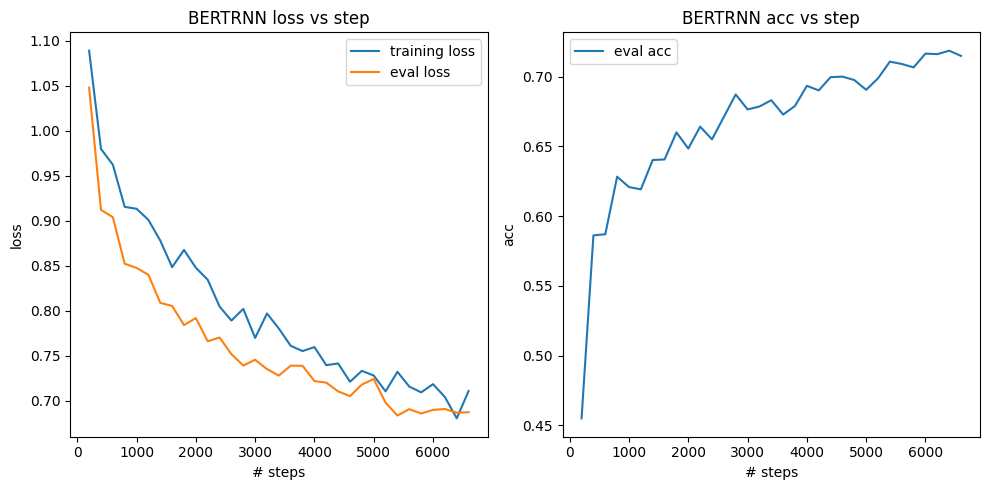

In [14]:
model_name = 'BERTRNN'

steps = []
train_loss = []
eval_loss = []
eval_acc = []

for i in range(0, len(log) - 1, 2):
    train_log = log[i]
    eval_log = log[i + 1]
    steps.append(train_log["step"])
    train_loss.append(train_log["loss"])
    eval_loss.append(eval_log["eval_loss"])
    eval_acc.append(eval_log["eval_accuracy"])

plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.title(f"{model_name} loss vs step")
plt.xlabel("# steps")
plt.ylabel("loss")
plt.plot(steps, train_loss, label="training loss")
plt.plot(steps, eval_loss, label="eval loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title(f"{model_name} acc vs step")
plt.xlabel("# steps")
plt.ylabel("acc")
plt.plot(steps, eval_acc, label="eval acc")
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
import json


with open(f"{model_name}_aug.json", "w") as f:
    json.dump(
        {
            "steps": steps,
            "train_loss": train_loss,
            "eval_loss": eval_loss,
            "eval_acc": eval_acc,
        },
        f,
        indent=4,
    )

In [ ]:
preds = trainer.predict(data["test"])

In [ ]:
pd.DataFrame(
    {"id": data["test"]["id"], "prediction": np.argmax(preds.predictions, axis=1)}
).to_csv(os.path.join(OUTPUT_DIR, "submission.csv"), header=True, index=False)